In [1]:
import pybullet as p
import numpy as np
from transforms3d.quaternions import *
from transforms3d.euler import *
from transforms3d.axangles import *
import json
import open3d as o3d
import matplotlib.pyplot as plt
import sys

sys.path.append("../")
from env.ycb_scene import SimulatedYCBEnv
from utils.utils import *
from utils.planner import GraspPlanner

pybullet build time: Dec  1 2021 18:33:43


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
'''
get data file name in json file and load mesh in pybullet
then reset robot and object position
'''

file = os.path.join("../object_index", 'ycb_large.json')
with open(file) as f: file_dir = json.load(f)
file_dir = file_dir['test']
file_dir = [f[:-5].split('.')[0][:-2] for f in file_dir]
test_file_dir = list(set(file_dir))

env = SimulatedYCBEnv()
env._load_index_objs(test_file_dir)
state = env.reset(save=False, enforce_face_target=True)

/home/ros/TM5_900_pybullet/env/models
>>>> target name: 006_mustard_bottle


## Get robot status by API in env

In [3]:
# Reset joint position
env._panda.reset()

# Get current status of end effector, specify "mat" argument to switch data expression
robot_pos = env._get_ef_pose()
robot_pos_mat = env._get_ef_pose(mat=True)
print(f"Position with quaternions:\n {robot_pos}\nPosition with SE(3) matrix:\n {robot_pos_mat}")

Position with quaternions:
 ((-0.6928049921989441, -0.8928982019424438, -0.8886162042617798), (0.6073547005653381, 0.742870032787323, 0.2180200219154358, 0.1781340092420578))
Position with SE(3) matrix:
 [[-1.98777143e-01  8.24697591e-01  5.29491766e-01 -6.92804992e-01]
 [ 9.80044702e-01  1.67175136e-01  1.07540018e-01 -8.92898202e-01]
 [ 1.70135671e-04  5.40302098e-01 -8.41471101e-01 -8.88616204e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


## Apply OMPL path planner with pre-define grasp pose

In [4]:
planner = GraspPlanner()

In [5]:
def expert_plan(goal_pose, world=False, visual=False):
    if world:
        pos, orn = env._get_ef_pose()
        ef_pose_list = [*pos, *orn]
    else:
        ef_pose_list = [0, 0, 0, 0, 0, 0, 1]
    goal_pos = [*goal_pose[:3], *ros_quat(goal_pose[3:])]

    solver = planner.plan(ef_pose_list, goal_pos)
    if visual:
        path_visulization(solver)
    path = solver.getSolutionPath().getStates()
    planer_path = []
    for i in range(len(path)):
        waypoint = path[i]
        rot = waypoint.rotation()
        action = [waypoint.getX(), waypoint.getY(), waypoint.getZ(), rot.w, rot.x, rot.y, rot.z]
        planer_path.append(action)

    return planer_path

In [6]:
def path_visulization(ss):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    x = []
    y = []
    z = []
    for i in range(len(ss.getSolutionPath().getStates())):
        state = ss.getSolutionPath().getStates()[i]
        x.append(state.getX())
        y.append(state.getY())
        z.append(state.getZ())
    ax.plot(x, y, z, color='gray', label='Curve')

    ax.scatter(x, y, z, c=z, cmap='jet', label='Points')
    plt.show()

### Set a pre-define coordinate relative to world/ef frame

In [7]:
env._panda.reset()

# A position in SE(3) relative to camera frame
desired_pt = np.array([[ 0.85913459, 0.50408285, 0.08825102, -0.09968021],
                      [-0.43048553, 0.61863272, 0.65724863, -0.13205695],
                      [ 0.27671279, -0.60265582, 0.74848914, 0.41399397],
                      [ 0. , 0. , 0. , 1. ]])

# Convert SE(3) to postion with quaternions [x, y, z, w, x, y, z]
target = pack_pose(desired_pt)

# Transform position from camera frame to flange
action = env.transform_pose_from_camera(target)
# SE(3) matrix relative to world frame
action_world = env._get_ef_pose(mat=True).dot(unpack_pose(action))

print(f"world frame:\n {action_world}\nrelative to ef: \n {action}")

world frame:
 [[ 6.72313844e-01 -7.29086062e-01 -1.28170240e-01 -2.96828072e-01]
 [-7.40266125e-01 -6.62253352e-01 -1.15873041e-01 -7.10840326e-01]
 [-3.99752374e-04  1.72783136e-01 -9.84959810e-01 -1.08543168e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
relative to ef: 
 [ 0.09968021  0.25065695  0.39485956  0.26015468  0.05246188 -0.35071809
  0.89808915]


### Plan with position relative to end effector frame

In [8]:
env._panda.reset()

# Get path list by GraspPlanner
plan = expert_plan(action)
# Get ef pose at beginning as initial pose
init_pos = env._get_ef_pose(mat=True)
for i in range(len(plan)):
    # Get current ef pose
    ef_pos = env._get_ef_pose(mat=True)
    # Transform path waypoint from initial pose based to current pose based
    next_pos_mat = np.dot(se3_inverse(ef_pos), init_pos.dot(unpack_pose(plan[i])))
    next_pos = pack_pose(next_pos_mat)
    env.step([*next_pos[:3], *quat2euler(next_pos[3:])], repeat=200)

startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce RTX 2080 Ti/PCIe/SSE2
GL_VERSION=3.3.0 NVIDIA 465.19.01
GL_SHADING_LANGUAGE_VERSION=3.30 NVIDIA via Cg compiler
pthread_getconcurrency()=0
Version = 3.3.0 NVIDIA 465.19.01
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce RTX 2080 Ti/PCIe/SSE2
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
numActiveThreads = 0
stopping threads
Thread with taskId 0 exiting
Thread TERMINATED
destroy semaphore
semaphore destroyed
destroy main semaphore
main semaphore destroyed


### Plan with position relative to world frame

Debug:   RRTstar: Planner range detected to be 7.242362
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 310
Info:    RRTstar: Found an initial solution with a cost of 1.79 in 7 iterations (8 vertices in the graph)
RRTstar found solution of path length 1.7858 with an optimization objective value of 1.7858
Interpolate Path length to 20
Info:    RRTstar: Created 724 new states. Checked 262450 rewire options. 1 goal states in tree. Final solution cost 1.786


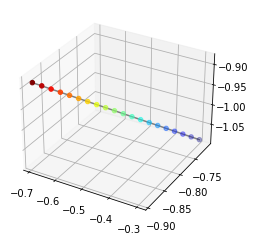

In [9]:
env._panda.reset()
# Get path list by GraspPlanner
plan = expert_plan(pack_pose(action_world), world=True, visual=True)
for i in range(len(plan)):
    # Set Target position with world frame based coordinate
    next_pos = plan[i]
    jointPoses = env._panda.solveInverseKinematics(next_pos[:3], ros_quat(next_pos[3:]))
    jointPoses[6] = 0
    jointPoses = jointPoses[:7].copy()
    obs = env.step(jointPoses, config=True, repeat=200)[0]